# Machine Learning Pipeline - Data Analysis

Implementation of each of the steps in the Machine Learning Pipeline. 

1. **Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

Plane Crash Dataset available on [Kaggle.com](https://www.kaggle.com/datasets/kamilkarczmarczyk/plane-crash-dataset-03042023). See below for more details.

===================================================================================================

Data description:
- Date: Date of accident, in the format - January 01, 2001
- Time: Local time, in 24 hr. format unless otherwise specified
- Airline/Op: Airline or operator of the aircraft
- Flight #: Flight number assigned by the aircraft operator
- Route: Complete or partial route flown prior to the accident
- AC Type: Aircraft type
- Reg: ICAO registration of the aircraft
- cn / ln: Construction or serial number / Line or fuselage number
- Aboard: Total aboard (passengers / crew)
- Fatalities: Total fatalities aboard (passengers / crew)
- Ground: Total killed on the ground
- Summary: Brief description of the accident and cause if known

# Data Analysis

In [ ]:
# ! python -m spacy download en_core_web_sm

In [1]:
# to handle datasets
import pandas as pd
import numpy as np
import datetime as dt
import re

from datetime import date as date_, time as time_
from pydantic import BaseModel, Field
import pandera as pa
from pandera.typing import DataFrame, Series
import pydantic
from typing import Optional

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import spacy
import gensim
from typing import Union
import logging
import itertools

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import spacy.cli
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")
# nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 4.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
logging.getLogger().setLevel(logging.INFO)
# logging.info(f"\033[033m***TEST***: {data.shape=}\033[0m") 

In [4]:
# load dataset
raw_data = pd.read_csv("data/raw_data.csv", sep=";")

# rows and columns of the data
logging.info(f"\033[36m {raw_data.shape=}\033[0m")

# visualise the dataset
raw_data.head()

INFO:root: raw_data.shape=(5028, 17)


,Date,Time:,Location:,AC Type:,Operator:,Route:,cn / ln:,Flight #:,Is_military,Military country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground:,Registration:,Summary:
0,18.03.1946,NaN,"Between Chungking and Shanghai, China",NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,?,?,?,?,NaN,139,Disappeared while en route. Plane never located.
1,09.11.1944,NaN,"Seljord, Norway",NaN,Military - U.S. Army Air Corps,NaN,NaN,NaN,Yes,U.S. Army Air Corps,?,?,?,?,NaN,42-52196,NaN
2,09.05.1989,NaN,"Near Tainjin, China",Bell 412,Aero Asahi,NaN,33070,NaN,No,NaN,?,?,10,?,0.0000,JA9596,NaN
3,20.02.1992,NaN,En route from Argentina to California,Boeing B-747,Aerolineas Argentinas,NaN,NaN,386,No,NaN,?,?,1,?,0.0000,NaN,A passenger died of cholera while en route.
4,13.03.1954,NaN,"Dien Bien Phu, South Vietnam",C-46,Aigle Azur,NaN,NaN,NaN,No,NaN,?,?,?,?,NaN,NaN,Shot down.


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   5028 non-null   object 
 1   Time:                  3482 non-null   object 
 2   Location:              5023 non-null   object 
 3   AC        Type:        5014 non-null   object 
 4   Operator:              5018 non-null   object 
 5   Route:                 4264 non-null   object 
 6   cn / ln:               4358 non-null   object 
 7   Flight #:              1338 non-null   object 
 8   Is_military            5018 non-null   object 
 9   Military country       766 non-null    object 
 10  Aboard_all             5028 non-null   object 
 11  Aboard_passengers      5028 non-null   object 
 12  Fatalities_all         5028 non-null   object 
 13  Fatalities_passengers  5028 non-null   object 
 14  Ground:                4984 non-null   float64
 15  Regi

In [39]:
# make a copy of original data to work with
data = raw_data.copy()

In [40]:
# rename columns
multiple_white_spaces = re.compile(r"\s+")
data.columns = [multiple_white_spaces.sub("_", _) for _ in (re.sub(r"[:/]", "", c) for c in data.columns)]

logging.info(f"\033[36m {data.columns=}\033[0m")

INFO:root: data.columns=Index(['Date', 'Time', 'Location', 'AC_Type', 'Operator', 'Route', 'cn_ln',
       'Flight_#', 'Is_military', 'Military_country', 'Aboard_all',
       'Aboard_passengers', 'Fatalities_all', 'Fatalities_passengers',
       'Ground', 'Registration', 'Summary'],
      dtype='object')


# Data schemas

In [8]:
class DataSchemaValidation(BaseModel):
    date: date_ = Field(alias="Date")
    time: time_ = Field(alias="Time")
    location: str = Field(alias="Location")
    ac_type: str = Field(alias="AC_Type")
    operator: str = Field(alias="Operator")
    route: str = Field(alias="Route")
    cn_ln: str = Field(alias="cn_ln")
    flight_n: str = Field(alias="Flight_#")
    is_military: str = Field(alias="Is_military")
    mlitary_country: str = Field(alias="Military_country")
    aboard_all: int = Field(alias="Aboard_all")
    aboard_passengers: int = Field(alias="Aboard_passengers")
    fatalities_all: int = Field(alias="Fatalities_all")
    fatalities_passengers: int = Field(alias="Fatalities_passengers")
    ground: int = Field(alias="Ground")
    registration: str = Field(alias="Registration")
    summary: str = Field(alias="Summary")
    year: Optional[int] = Field(alias="Year")
    month: Optional[int] = Field(alias="Month")
    hour: Optional[int] = Field(alias="Hour")
    routes_n: Optional[int] = Field(alias="Routes_#")
    vector: Optional[list] = Field(alias="Vector")
    fatalities: Optional[int] = Field(alias="Fatalities")
    survived: Optional[int] = Field(alias="Survived")
    survived_pct: Optional[float] = Field(alias="Survived_pct")


class DataSchema:
    date = "Date"
    time = "Time"
    location = "Location"
    ac_type = "AC_Type"
    operator = "Operator"
    route = "Route"
    cn_ln = "cn_ln"
    flight_n = "Flight_#"
    is_military = "Is_military"
    mlitary_country = "Military_country"
    aboard_all = "Aboard_all"
    aboard_passengers = "Aboard_passengers"
    fatalities_all = "Fatalities_all"
    fatalities_passengers = "Fatalities_passengers"
    ground = "Ground"
    registration = "Registration"
    summary = "Summary"
    year = "Year"
    month = "Month"
    hour = "Hour"
    routes_n = "Routes_#"
    vector = "Vector"
    fatalities = "Fatalities"
    survived = "Survived"
    survived_pct = "Survived_pct"

## Missing values/ Unique values

In [41]:
# list of columns to drop after EDA
redundant_columns = []

# replace missing values in form of "?"
data = data.replace("?", np.nan)

In [80]:
def get_pct_missing_and_unique(col: str) -> None:
    logging.info(f"\033[35m{col} field has {data[col].isna().sum()/data.shape[0]:.2%} missing values\033[0m")
    logging.info(f"\033[32m{col} field has {data[col].nunique()/data.shape[0]:.2%} unique values\033[0m")

In [81]:
for col in data.columns:
    get_pct_missing_and_unique(col)

INFO:root:Date field has 0.00% missing values
INFO:root:Date field has 91.47% unique values
INFO:root:Time field has 29.99% missing values
INFO:root:Time field has 21.41% unique values
INFO:root:Location field has 0.10% missing values
INFO:root:Location field has 82.29% unique values
INFO:root:AC_Type field has 0.22% missing values
INFO:root:AC_Type field has 48.38% unique values
INFO:root:Operator field has 0.18% missing values
INFO:root:Operator field has 45.26% unique values
INFO:root:Route field has 14.41% missing values
INFO:root:Route field has 77.26% unique values
INFO:root:cn_ln field has 12.80% missing values
INFO:root:cn_ln field has 78.57% unique values
INFO:root:Flight_# field has 73.07% missing values
INFO:root:Flight_# field has 18.17% unique values
INFO:root:Is_military field has 0.18% missing values
INFO:root:Is_military field has 0.04% unique values
INFO:root:Military_country field has 84.89% missing values
INFO:root:Military_country field has 4.25% unique values
INFO:

In [43]:
# plot columns in discending order of percent unique for columns with more then 1 unique values
def plot_pct_unique(data: DataFrame) -> None:
    df = data.copy()
    # make a list of the variables that contain unique values
    vars_with_unique = [var for var in df.columns if df[var].nunique()/data.shape[0] > 0]

    # determine percentage of unique values (expressed as decimals)
    # and display the result ordered by % of unique data
    table = df[vars_with_unique].nunique().sort_values(ascending=False)/df.shape[0]
    print(table)
    
    # plot
    table.plot.bar(figsize=(10, 4))
    plt.ylabel('Percentage of unique data')
    plt.axhline(y=0.80, color='r', linestyle='-')
    plt.axhline(y=0.15, color='g', linestyle='-')

    plt.show()


# plot columns with missing values in discending order of percent missing
def plot_pct_missing(data: DataFrame) -> None:
    df = data.copy()
    # make a list of the variables that contain missing values
    vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

    # determine percentage of missing values (expressed as decimals)
    # and display the result ordered by % of missin data
    print(df[vars_with_na].isnull().mean().sort_values(ascending=False))
    
    # plot
    df[vars_with_na].isnull().mean().sort_values(
        ascending=False).plot.bar(figsize=(10, 4))
    plt.ylabel('Percentage of missing data')
    plt.axhline(y=0.80, color='r', linestyle='-')
    plt.axhline(y=0.15, color='g', linestyle='-')

    plt.show()

Military_country        0.8477
Flight_#                0.7339
Time                    0.3075
Route                   0.1519
cn_ln                   0.1333
Registration            0.0547
Fatalities_passengers   0.0467
Aboard_passengers       0.0440
Summary                 0.0117
Ground                  0.0088
Aboard_all              0.0034
AC_Type                 0.0028
Operator                0.0020
Is_military             0.0020
Fatalities_all          0.0016
Location                0.0010
dtype: float64


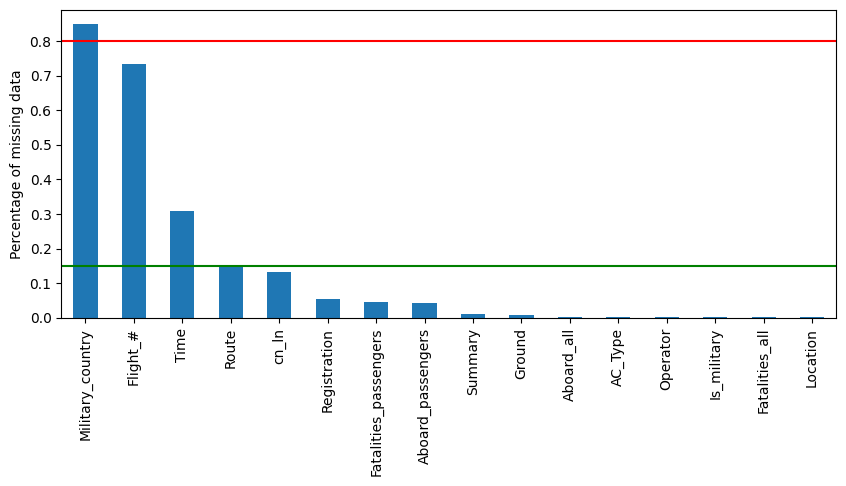

In [44]:
plot_pct_missing(data)

Summary                 0.9696
Registration            0.9381
Date                    0.9141
Location                0.8230
cn_ln                   0.7802
Route                   0.7655
AC_Type                 0.4819
Operator                0.4507
Time                    0.2116
Flight_#                0.1796
Aboard_all              0.0485
Aboard_passengers       0.0465
Military_country        0.0426
Fatalities_all          0.0396
Fatalities_passengers   0.0378
Ground                  0.0099
Is_military             0.0004
dtype: float64


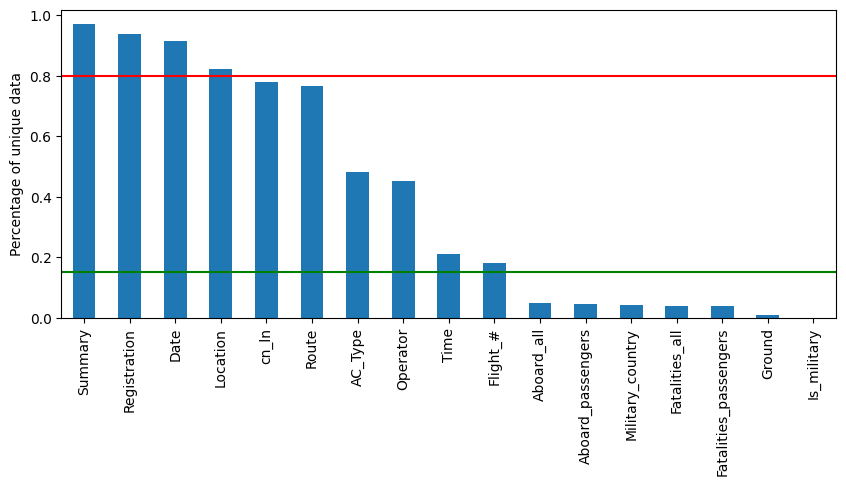

In [45]:
plot_pct_unique(data)

In [46]:
redundant_columns.extend([DataSchema.mlitary_country, DataSchema.flight_n, DataSchema.time])

# Drop samples that has missing values in columns

In [85]:
test = data.copy()
vars_with_na = [var for var in data.columns if data[var].isnull().sum()/data.shape[0] < 0.15]
test.dropna(subset=vars_with_na, inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{test.shape=}\033[0m")
logging.info(f"\033[35mtest dataset reduced by {1-test.shape[0]/raw_data.shape[0]:.2%} dropping samples w/ nan in columns w/ mssings values under 15%\033[0m")
test = data.copy()
vars_with_na = [var for var in data.columns if data[var].isnull().sum()/data.shape[0] < 0.05]
test.dropna(subset=vars_with_na, inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{test.shape=}\033[0m")
logging.info(f"\033[35mtest dataset reduced by {1-test.shape[0]/raw_data.shape[0]:.2%} dropping samples w/ nan in columns w/ mssings values under 5%\033[0m")

data.dropna(subset=[DataSchema.summary], inplace=True)
logging.info(f"\033[36m{raw_data.shape=}\n{' '*10}{data.shape=}\033[0m")
logging.info(f"\033[32mdataset reduced by {1-data.shape[0]/raw_data.shape[0]:.2%} dropping samples with missing summary\033[0m")

INFO:root:raw_data.shape=(5028, 17)
          test.shape=(3833, 17)
INFO:root:test dataset reduced by 23.77% dropping samples w/ nan in columns w/ mssings values under 15%
INFO:root:raw_data.shape=(5028, 17)
          test.shape=(4723, 17)
INFO:root:test dataset reduced by 6.07% dropping samples w/ nan in columns w/ mssings values under 5%
INFO:root:raw_data.shape=(5028, 17)
          data.shape=(4969, 17)
INFO:root:dataset reduced by 1.17% dropping samples with missing summary


# Route

In [24]:
data[DataSchema.route].sample(5)

4830          Birmingham, England - Malaga, Spain
4094    Mexico City - New Orleans - New York City
3249                           Ban Xon - Pha Khao
207                                      Training
4117                           Kinshasa - Kahemba
Name: Route, dtype: object

In [25]:
# get number of routes(airports)
def get_multiple_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    route = text.split(" - ")    
    for point in route:
        doc = nlp(point)
        for ent in doc.ents:
            if ent.label_=="GPE":
                point = ent.text
    flatten = list(itertools.chain(*[[j] if isinstance(j, str) else j for j in [i.split(", ") for i in route]]))
    return flatten

In [26]:
# TEST
routes = [
    "Sukhumi - Kutaisi", "Test flight", np.nan, "Bombing run", 
    "Boston - NY - Washington DC - Jacksonville - Miami", "Lima - Pucallpa - Iquitos"]
for _ in routes:
    x = get_multiple_locations(_)
    print(x)

['Sukhumi', 'Kutaisi']
['Test flight']
nan
['Bombing run']
['Boston', 'NY', 'Washington DC', 'Jacksonville', 'Miami']
['Lima', 'Pucallpa', 'Iquitos']


In [27]:
# replace Route free text value with list of destinations per flight
data[DataSchema.route] = data[DataSchema.route].apply(lambda x: get_multiple_locations(x))

In [28]:
# create new column derived from Route and represented number of routes per flight
data[DataSchema.routes_n] = data[DataSchema.route].apply(lambda x: 0 if x is np.nan else len(x))

In [29]:
data[DataSchema.routes_n].value_counts()

Routes_#
2    2913
0     764
4     452
3     442
1     371
5      59
6      26
7       1
Name: count, dtype: int64

In [30]:
redundant_columns.append(DataSchema.route)

## Date: extract year and month

In [33]:
# extract year and month from date into separate columns
data[DataSchema.year] = pd.to_datetime(data[DataSchema.date]).dt.year
data[DataSchema.month] = pd.to_datetime(data[DataSchema.date]).dt.month
redundant_columns.append(DataSchema.date)

In [ ]:
# TODO
break

## Location: extract state

In [83]:
data[DataSchema.location]

0                   Between Chungking and Shanghai, China
3                 En route from Argentina  to  California
4                            Dien Bien Phu, South Vietnam
6                                          Kunming, China
8                                     Over North Carolina
                              ...                        
5023                          Ras-al-Mishab, Saudi Arabia
5024                               Near Ardmore, Oklahoma
5025                                   Almaty, Kazakhstan
5026                                    Karachi, Pakistan
5027    North Atlantic Ocean, 100 miles W of Galway Ba...
Name: Location, Length: 4969, dtype: object

In [82]:
def get_locations(text: str) -> Union[None, str]:    
    if text is np.nan:
        return text
    locations = [] 
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_=="GPE":
            locations.append(ent.text)
    return locations[-1] if locations else text

In [84]:
data[DataSchema.location] = data[DataSchema.location].apply(lambda x: get_locations(x))
data[DataSchema.location]

KeyboardInterrupt: 

In [ ]:
print(f"\033[31mLocation field after parsing for country has {data[DataSchema.LOCATION].nunique()/data.shape[0]:.2%} unique values\033[0m")

## AC Type: check for missing values

In [87]:
data[DataSchema.ac_type]

0                                      NaN
3                             Boeing B-747
4                                     C-46
6                             Douglas C-47
8                             Douglas DC-3
                       ...                
5023                       Lockheed C-130H
5024                 Lockheed 188C Electra
5025                            Fokker 100
5026                       Airbus A320-214
5027    Lockheed 1049H Super Constellation
Name: AC_Type, Length: 4969, dtype: object

In [86]:
data[data[DataSchema.ac_type].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary
0,18.03.1946,NaN,"Between Chungking and Shanghai, China",NaN,China National Aviation Corporation,Chunking - Shanghai,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,139,Disappeared while en route. Plane never located.
22,08.11.1943,NaN,"Poona, India",NaN,Military - Indian Air Force,NaN,NaN,NaN,Yes,Indian Air Force,1,NaN,1,NaN,37.0000,NaN,Crashed into a village.
1284,08.04.1922,NaN,"Pao Ting Fou, China",NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...
1616,29.06.1945,NaN,"Bangalore, India",NaN,Military - Royal Indian Air Force,NaN,NaN,NaN,Yes,Royal Indian Air Force,2,NaN,2,NaN,36.0000,NaN,Crashed into a village exploding and destoying...
1623,08.08.1951,21:00:00,"Barilla Bay, Australia",NaN,Trans Australia Airlines,Hobart Melbourne,13083,NaN,No,NaN,2,0,2,0,0.0000,VH-TAT,Cargo plane. Loss of lateral control during a ...
1862,17.03.1946,NaN,"Near Nanking, China",NaN,Military - Chinese Air Force,Shanghai - Nanking,NaN,NaN,Yes,Chinese Air Force,20,NaN,20,NaN,0.0000,NaN,Crashed into mountainous terrain in low visibi...
1863,11.02.1996,NaN,"Near Kandahar, Afghanistan",NaN,Military - Taliban Militia,NaN,NaN,NaN,Yes,Taliban Militia,20,NaN,20,NaN,0.0000,NaN,The helicopter was shot down.
2625,22.11.1961,NaN,"Harare, Zimbabwe",NaN,Rhodesian Air Services,Salisbury - Livingstone - Elizabethville,19351,NaN,No,NaN,3,0,3,0,0.0000,VP-YRX,The aircraft was on a charter flight to Living...
3451,15.07.1967,NaN,"Near Williamsport, Newfoundland, Canada",NaN,Eastern Provincial Airways,NaN,NaN,NaN,No,NaN,4,3,4,3,0.0000,NaN,Crashed minutes after takeoff.
4551,26.03.1952,NaN,"Moscow, Russia",NaN,Aeroflot,NaN,NaN,NaN,No,NaN,70,NaN,70,NaN,0.0000,NaN,The plane overshot the runway and collided wit...


In [ ]:
# TODO group Aircraft types

## Operator

In [89]:
data[DataSchema.operator]

0       China National Aviation Corporation
3                     Aerolineas Argentinas
4                                Aigle Azur
6       China National Aviation Corporation
8                                  Piedmont
                       ...                 
5023       Military - Royal Saudi Air Force
5024                American Flyers Airline
5025                                Bek Air
5026         Pakistan International Airline
5027               KLM Royal Dutch Airlines
Name: Operator, Length: 4969, dtype: object

In [88]:
data[data[DataSchema.operator].isna()]

,Date,Time,Location,AC_Type,Operator,Route,cn_ln,Flight_#,Is_military,Military_country,Aboard_all,Aboard_passengers,Fatalities_all,Fatalities_passengers,Ground,Registration,Summary
158,07.09.1909,NaN,"Juvisy-sur-Orge, France",Wright Byplane,NaN,Air show,NaN,NaN,NaN,NaN,1,0,1,0,0.0000,SC1,Eugene Lefebvre was the first pilot to ever be...
728,04.07.1943,23:00:00,Gibraltar,Consolidated Liberator B24 C,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,12,NaN,0.0000,A-L-523,"The flight, bound for London, crashed into the..."
1145,17.06.1917,NaN,"Near Yarmouth, England",Zepplin L-48 (air ship),NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,14,NaN,0.0000,L-48,Shot down by aircraft.
1189,02.09.1963,NaN,Northeast Laos,Curtiss C-46 Commando,NaN,NaN,NaN,NaN,NaN,NaN,16,13,15,12,NaN,NaN,Refugee flight.
1284,08.04.1922,NaN,"Pao Ting Fou, China",NaN,NaN,Test,NaN,NaN,NaN,NaN,17,0,17,0,0.0000,NaN,Aboard were all workers taking part in a fligh...
2847,26.12.2011,05:54:00,"Green Grove, Florida",Bell 206B,NaN,"Jacksonville, FL - Gainsville, FL",2636,NaN,NaN,NaN,3,2,3,2,0.0000,N5016M,The on-demand air taxi was on a flight to proc...
2892,04.07.1922,NaN,"Fuhlsbuttel, Germany",LVG C VI,NaN,Hamburg - Berlin,NaN,NaN,NaN,NaN,3,2,2,1,0.0000,NaN,The passenger/mail plane lost it's engine whil...
3932,26.09.1926,NaN,"New York, New York",Sikorsky S-25,NaN,New York - Paris,NaN,NaN,NaN,NaN,5,4,2,2,0.0000,NaN,Too much weight caused the landing gear to col...
4847,29.05.1935,NaN,"San Barbra, Honduras",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,6,NaN,0.0000,NaN,Crashed into the Ulua River.


In [ ]:
def get_operatos_list(text: str) -> Union[None, list]:
    if text is np.nan:
        return text
    if "test" in text.lower():
        return text
    operators = []
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == "ORG":
            operators.append(ent.text)
    return operators[-1] if operators else text

In [ ]:
# TEST
x = [np.nan, "Military - U.S. Army Air Corps", "Test", "American Flyers Airline", "KLM Royal Dutch Airlines", "Air Canada"]
for i in x:
    y = get_operatos_list(i)
    print(y)
    print("==========================")

In [ ]:
tmp = data.copy()
tmp["tmp"] = tmp[DataSchema.OPERATOR].apply(lambda x: get_operatos_list(x))

In [ ]:
tmp["tmp"].sample(5)

In [ ]:
print(f"\033[35mOperator field after organisation extraction has {tmp['tmp'].nunique()/data.shape[0]:.2%} unique values\033[0m")

In [ ]:
# TODO consider to use tf-idf
redundant_columns.append(DataSchema.OPERATOR)

## Construction or serial number / Line or fuselage number

In [ ]:
data[data[DataSchema.cn_ln].notna()][DataSchema.cn_ln]

In [ ]:
redundant_columns.append(DataSchema.CN_LN)

## Flight number

In [ ]:
get_pct_missing_and_unique(DataSchema.FLIGHT_N, "Flight number")

In [ ]:
data[data[DataSchema.FLIGHT_N].notna()][DataSchema.FLIGHT_N].sample(5)

In [ ]:
redundant_columns.append(DataSchema.FLIGHT_N)

## Is Military

In [ ]:
get_pct_missing_and_unique(DataSchema.IS_MILITARY, "Is Military")

In [ ]:
# TODO consider to drop military samples
redundant_columns.append(DataSchema.IS_MILITARY)

## Military country

In [ ]:
get_pct_missing_and_unique(DataSchema.MILITARY_COUNTRY)

In [ ]:
redundant_columns.append(DataSchema.MILITARY_COUNTRY)

## Aboard All

In [ ]:
get_pct_missing_and_unique(DataSchema.ABOARD_ALL, "Aboard All")

In [ ]:
data.dropna(subset=[DataSchema.ABOARD_ALL], inplace=True)

## Abroad Passengers

In [ ]:
get_pct_missing_and_unique(DataSchema.ABOARD_PASSENGERS, "Abroad Passengers")

## Fatalities All

In [ ]:
get_pct_missing_and_unique(DataSchema.FATALITIES_ALL, "Fatalities All")

In [ ]:
data.dropna(subset=[DataSchema.FATALITIES_ALL], inplace=True)

## Fatalities Passengers

In [ ]:
get_pct_missing_and_unique(DataSchema.FATALITIES_PASSENGERS, "Fatalities Passengers")

## Ground

In [ ]:
get_pct_missing_and_unique(DataSchema.GROUND, "Ground")

In [ ]:
data[DataSchema.GROUND].fillna(0, inplace = True)

In [ ]:
data[DataSchema.GROUND].value_counts()
# data[data[DataSchema.GROUND]==2750]

In [ ]:
# TODO replace np.nan with mean which is 0 and change type to int

In [ ]:
fatalities = [
    DataSchema.ABOARD_ALL, DataSchema.ABOARD_PASSENGERS, 
    DataSchema.FATALITIES_ALL, DataSchema.FATALITIES_PASSENGERS, DataSchema.GROUND]
data[fatalities].sample(10)

In [ ]:
def get_pct_fatalities(row):
    if row[DataSchema.ABOARD_ALL] is not np.nan and row[DataSchema.FATALITIES_ALL]is not np.nan and int(row[DataSchema.ABOARD_ALL])!=0:
        return int(row[DataSchema.FATALITIES_ALL])/int(row[DataSchema.ABOARD_ALL])*100
    return -1

all = data.apply(lambda x: get_pct_fatalities(x), axis=1)

def get_pct_fatalities_passwnger(row):
    if row[DataSchema.ABOARD_ALL] is not np.nan and row[DataSchema.FATALITIES_PASSENGERS]is not np.nan and int(row[DataSchema.ABOARD_ALL])!=0:
        return int(row[DataSchema.FATALITIES_PASSENGERS])/int(row[DataSchema.ABOARD_ALL])*100
    return -1

passengers = data.apply(lambda x: get_pct_fatalities(x), axis=1)

def get_pct_fatalities_passwnger(row):
    if row[DataSchema.ABOARD_ALL] is not np.nan and row[DataSchema.FATALITIES_PASSENGERS]is not np.nan and int(row[DataSchema.ABOARD_ALL])!=0:
        return (int(row[DataSchema.FATALITIES_ALL])-int(row[DataSchema.FATALITIES_PASSENGERS]))/int(row[DataSchema.ABOARD_ALL])*100
    return -1

crew = data.apply(lambda x: get_pct_fatalities(x), axis=1)

sns.histplot(all)

In [ ]:
redundant_columns.append(DataSchema.GROUND)

## Registration

In [ ]:
get_pct_missing_and_unique(DataSchema.REGISTRATION, "Registration")

In [ ]:
data[DataSchema.REGISTRATION].sample(5)

In [ ]:
redundant_columns.append(DataSchema.REGISTRATION)

## Summary

In [ ]:
get_pct_missing_and_unique(DataSchema.SUMMARY, "Summary")

In [ ]:
data.dropna(subset=[DataSchema.SUMMARY], inplace=True)
data[DataSchema.SUMMARY]

In [ ]:
info = api.info()
for model_name, model_data in sorted(info["models"].items()):
    print("%s (%d records) %s..." % (model_name, model_data.get("num_records", -1), model_data["description"][:40]))

In [ ]:
w2v = api.load("word2vec-google-news-300")

### Castom data Word2Vec model

In [ ]:
break

In [ ]:
def get_preprocessed(text):
    doc = nlp(text)

    filtered = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered.append(token.lemma_)
    return filtered

corpus = data[DataSchema.SUMMARY].apply(lambda text: get_preprocessed(text)).tolist()
model_default = Word2Vec(sentences=corpus) # 100-dimentional vector by default
model_vs100 = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)
model_vs50 = Word2Vec(sentences=corpus, vector_size=50, window=5, min_count=1, workers=4)
# model.save("word2vec.model")
# model = Word2Vec.load("word2vec.model")


In [ ]:
# plot embadings in 2-dimensional spase

def reduce_dimensions(model):
    n_components = 2 # dimentions
    # extract vocabulary from model and vectors in order to associate them in the graph
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)
    #apply TSNE
    tsne = TSNE(n_components=n_components, random_state=42)
    vectors = tsne.fit_transform(vectors)
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode="markers", text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualisation embedding with TSNE")
    fig.show()
    return fig


x_vals, y_vals, labels = reduce_dimensions(model)
plot = plot_embeddings(x_vals, y_vals, labels)

In [ ]:
# preprocessing (remove stop words, lemmitize)

def text2vec(text):
    doc = nlp(text)

    filtered = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        filtered.append(token.lemma_)
    return w2v.get_mean_vector(filtered, pre_normalize=True)

### Sense check

In [ ]:
# print(w2v.similarity("plane","passanger"))
# print(w2v.most_similar(positive=["plane"], topn=3))

In [ ]:
data[DataSchema.VECTOR] = data[DataSchema.SUMMARY].apply(lambda text: text2vec(text))

In [ ]:
data[DataSchema.VECTOR]

# Target

In [ ]:
for col in [DataSchema.ABOARD_ALL, DataSchema.FATALITIES_ALL, DataSchema.GROUND]:
    data[col] = data[col].astype(int)

In [ ]:
data[DataSchema.FATALITIES] = data[DataSchema.FATALITIES_ALL]+data[DataSchema.GROUND]
data[DataSchema.SURVIVED] = data[DataSchema.ABOARD_ALL]-data[DataSchema.FATALITIES_ALL]

In [ ]:
data[DataSchema.FATALITIES].value_counts()

In [ ]:
data[DataSchema.SURVIVED].value_counts()

In [ ]:
data[DataSchema.SURVIVED] = np.where(data[DataSchema.SURVIVED] > 0, 1, data[DataSchema.SURVIVED])

In [ ]:
data[DataSchema.SURVIVED].value_counts()

In [ ]:
data[DataSchema.SURVIVED_PCT] = data[DataSchema.SURVIVED]/data[DataSchema.ABOARD_ALL]*100
data[DataSchema.SURVIVED_PCT].value_counts()

### Summary vectors as features to predict survival percentage

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data[DataSchema.VECTOR].values,
    data[DataSchema.SURVIVED],
    test_size=0.2,
    random_state=42,
    stratify=data[DataSchema.SURVIVED]
)

In [ ]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [ ]:
print(f"{X_train_2d.shape=}")
print(f"{X_test_2d.shape=}")

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(X_train_2d, y_train)
y_pred = clf.predict(X_test_2d)
print(classification_report(y_test, y_pred))